In [1]:
import progressbar
import h5py
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pytz
import warnings
import pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import search_dispersion_events 
import importlib
importlib.reload(search_dispersion_events)

<module 'search_dispersion_events' from '/mnt/c/Users/dedasilv/OneDrive - NASA/Desktop/dmsp_data/search_dispersion_events.py'>

In [2]:
df = pd.read_csv('data/train.csv', parse_dates=['start_time', 'end_time'])
df.head()

,class,filename,sat,date,start_time,end_time
0,0,data/2015/12/21/dms_20151221_16e.001.hdf5,16,2015-12-21,2015-12-21 09:16:00+00:00,2015-12-21 09:18:00+00:00
1,1,data/2015/12/20/dms_20151220_19e.001.hdf5,19,2015-12-20,2015-12-20 04:05:00+00:00,2015-12-20 04:07:00+00:00
2,0,data/2015/03/17/dms_20150317_18e.001.hdf5,18,2015-03-17,2015-03-17 11:13:00+00:00,2015-03-17 11:18:00+00:00
3,0,data/2011/08/06/dms_20110806_16e.001.hdf5,16,2011-08-06,2011-08-06 11:02:00+00:00,2011-08-06 11:06:00+00:00
4,0,data/2015/12/20/dms_20151220_18e.001.hdf5,18,2015-12-20,2015-12-20 05:56:00+00:00,2015-12-20 05:58:00+00:00


In [81]:
def get_metrics(row):
    importlib.reload(search_dispersion_events)
    
    # Do computation --------------------------------------------------
    fh = search_dispersion_events.read_file(row.filename)

    dEicdt_smooth, Eic = search_dispersion_events.estimate_log_Eic_smooth_derivative(fh)

    _, integrand,integral, upper_area_frac = search_dispersion_events.walk_and_integrate(
        fh, dEicdt_smooth, Eic, search_dispersion_events.DEFAULT_INTERVAL_LENGTH,
        return_integrand=True
    )
        
    i = fh['t'].searchsorted(row.start_time)
    j = fh['t'].searchsorted(row.end_time)

    return row.name, integral[i:j].max(), upper_area_frac[i:j].max(), fh['mlat'][i], fh['mlat'][j]

In [83]:
from joblib import Parallel, delayed

disp_df = df[df['class'] == 1]
metric_rows = Parallel(n_jobs=12)(delayed(get_metrics)(row) for _, row in disp_df.iterrows())
metric_df = pd.DataFrame(metric_rows, columns=['row_name', 'integral', 'upper_area_frac', 'mlat_start', 'mlat_end'])

/home/daniel/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


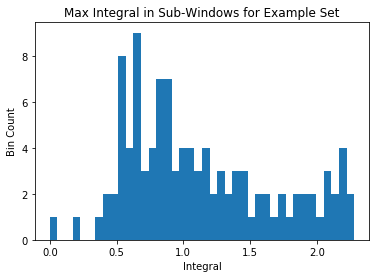

In [85]:
plt.hist(metric_df.integral, bins=40)
plt.xlabel('Integral')
plt.ylabel('Bin Count')
plt.title('Max Integral in Sub-Windows for Example Set')
None

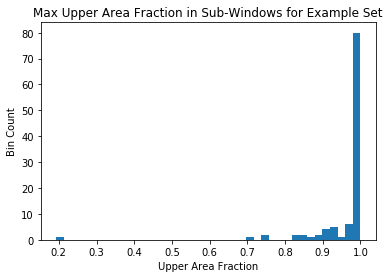

In [87]:
plt.hist(metric_df.upper_area_frac, bins=40)
plt.xlabel('Upper Area Fraction')
plt.ylabel('Bin Count')
plt.title('Max Upper Area Fraction in Sub-Windows for Example Set')

None